# US Legislation Summarization

## Data Description

The dataset was taken from: https://www.kaggle.com/datasets/undersc0re/billsum-processed-train?select=ustrain_processed.csv

The datset contains the text of bills and human-written summaries from the US Congress Legislature. The corpus consists of bills from the 103rd-115th (1993-2016) sessions of Congress.

## Importing necessary libraries & loading data

In [1]:
%%capture
! pip install transformers==4.5.0
! pip install rouge_score
! pip install datasets

In [2]:
# installing apex
%%writefile setup.sh
git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --disable-pip-version-check --no-cache-dir ./

Writing setup.sh


In [3]:
%%capture
!sh setup.sh

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch
from tqdm.autonotebook import tqdm
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, load_metric, Dataset, load_from_disk
from apex import amp
import os
from google.colab import drive

In [5]:
drive.mount('drive')

Mounted at drive


In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d undersc0re/billsum-processed-train

 99% 52.0M/52.7M [00:02<00:00, 31.1MB/s]
100% 52.7M/52.7M [00:02<00:00, 24.6MB/s]


In [10]:
%%capture
! unzip billsum-processed-train.zip

In [11]:
train_df = pd.read_csv('/content/ustrain_processed.csv')
train_df.head()

,bill_id,clean_text,summary,sum_len,text_len,cleantext_len
0,107_hr2256,SECTIONHEADER SHORT TITLE. This Act may be cit...,Border Hospital Survival and Illegal Immigrant...,527,6100,4999
1,111_hr4710,SECTIONHEADER SHORT TITLE. This Act may be cit...,Farm to School Improvements Act of 2010 - Amen...,1161,8628,6215
2,107_s409,SECTIONHEADER SHORT TITLE. This Act may be cit...,Persian Gulf War Illness Compensation Act of 2...,694,5567,4624
3,109_s2759,SECTIONHEADER SHORT TITLE. This Act may be cit...,Medicare Part D Outreach and Enrollment Enhanc...,810,6361,4408
4,107_hr5568,SECTIONHEADER SHORT TITLE. This Act may be cit...,Seniors' Retirement Recovery Act of 2002 - Ame...,380,5368,4081


In [12]:
train_df['clean_text'].loc[0]

'SECTIONHEADER SHORT TITLE. This Act may be cited as the "Border Hospital Survival and Illegal Immigrant Care Act". SECTIONHEADER FINDINGS. The Congress finds as follows: Immigration is a Federal responsibility. The Immigration and Naturalization Service does not take into custody all aliens who are unlawfully present in the United States. Section 1867 of the Social Security Act and State laws require that, if any individual comes to a hospital and the hospital determines that the individual has an emergency medical condition, the hospital must provide either, within the staff and facilities available at the hospital, for such further medical examination and such treatment as may be required to stabilize the medical condition, or, if appropriate, for transfer of the individual to another medical facility. The Southwest border region is ill-equipped to absorb the expense of providing health care to undocumented aliens because it ranks last in the country in terms of per capita income. T

In [13]:
train_df['summary'].loc[0]

'Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary of Health and Human Services to establish a five-year pilot program of health care provider reimbursement for the costs associated with providing emergency medical and ambulance services in Arizona to: (1) illegal aliens who are not detained by any Federal, State, or local law enforcement authority. Or (2) aliens paroled into the United States for less than one year to receive emergency medical treatment.'

Longformer - neural network architecture that I am going to use for summarization - is very computationaly expensive. Training on the whole BillSum dataset will take 56 hours, so I will reduce training and validation data to make training possible in colab.

In [14]:
train_df.drop(['bill_id', 'sum_len', 'text_len', 'cleantext_len'], axis=1, inplace=True)
train_df = train_df.sample(500, random_state=42)

In [15]:
val_df = pd.read_csv('/content/ustest_processed.csv')
val_df.drop(['bill_id', 'sum_len', 'text_len', 'cleantext_len'], axis=1, inplace=True)
val_df = val_df.sample(20, random_state=42)

## Data Preprocessing

In [16]:
tokenizer = AutoTokenizer.from_pretrained('allenai/led-base-16384')

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

In [17]:
text_token_counts = []
summary_token_counts = []
for _, row in tqdm(train_df.iterrows()):
  text_token_count = len(tokenizer.encode(row['clean_text']))
  text_token_counts.append(text_token_count)
  summary_token_count = len(tokenizer.encode(row['summary']))
  summary_token_counts.append(summary_token_count)

0it [00:00, ?it/s]

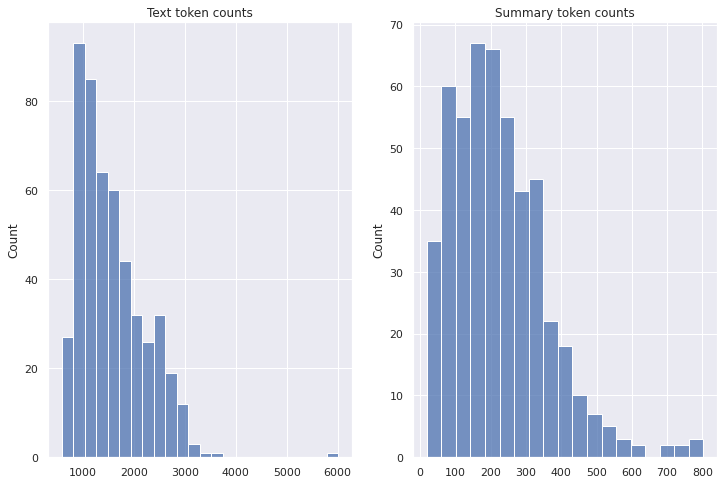

In [20]:
# visualizing token length distribution
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(12, 8))
sns.set_theme()

sns.histplot(text_token_counts, ax=ax_1)
ax_1.set_title('Text token counts')

sns.histplot(summary_token_counts, ax=ax_2)
ax_2.set_title('Summary token counts');

In [ ]:
max(text_token_counts), max(summary_token_counts), min(summary_token_counts)

(6012, 803, 19)

In [25]:
encoder_max_length = 3800
decoder_max_length = 803
batch_size = 4

In [ ]:
train_df = Dataset.from_pandas(train_df)
val_df = Dataset.from_pandas(val_df)

In [ ]:
def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(batch['clean_text'],
                     padding='max_length',
                     truncation=True,
                     max_length=encoder_max_length)
  
  outputs = tokenizer(batch['summary'],
                      padding='max_length',
                      truncation=True,
                      max_length=decoder_max_length)

  batch['input_ids'] = inputs.input_ids
  batch['attention_mask'] = inputs.attention_mask

  # create 0 global_attention_mask lists
  batch['global_attention_mask'] = len(batch['input_ids']) * [[0 for _ in range(len(batch['input_ids'][0]))]]

  # since above lists are references, the following line changes the 0 index for all samples
  batch['global_attention_mask'][0][0] = 1
  batch['labels'] = outputs.input_ids

  # We have to make sure that the PAD token is ignored
  batch['labels'] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch['labels']]
  return batch

In [ ]:
# map train data
train_df = train_df.map(process_data_to_model_inputs,
                        batched=True,
                        batch_size=batch_size,
                        remove_columns=['clean_text', 'summary'])

  0%|          | 0/125 [00:00<?, ?ba/s]

In [ ]:
train_df.save_to_disk('leg_sum_train.hf')

In [ ]:
! mv '/content/leg_sum_train.hf' '/content/drive/My Drive/Data/'

In [21]:
train_df = load_from_disk('/content/drive/MyDrive/Data/leg_sum_train.hf')

In [ ]:
# map val data
val_df = val_df.map(process_data_to_model_inputs,
                    batched=True,
                    batch_size=batch_size,
                    remove_columns=['clean_text', 'summary'])

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
val_df.save_to_disk('leg_sum_val.hf')

In [ ]:
! mv '/content/leg_sum_val.hf' '/content/drive/My Drive/Data/'

In [22]:
val_df = load_from_disk('/content/drive/MyDrive/Data/leg_sum_val.hf')

In [23]:
# set Python list to PyTorch tensor
train_df.set_format(type='torch', columns=['input_ids', 'attention_mask', 'global_attention_mask', 'labels'])
val_df.set_format(type='torch', columns=['input_ids', 'attention_mask', 'global_attention_mask', 'labels'])

## Model Training

In [26]:
# enable fp16 apex training
training_args = Seq2SeqTrainingArguments(predict_with_generate=True,
                                         evaluation_strategy='epoch',
                                         per_device_train_batch_size=batch_size,
                                         per_device_eval_batch_size=batch_size,
                                         fp16=True,
                                         output_dir='./',
                                         logging_steps=5,
                                         eval_steps=10,
                                         save_steps=10,
                                         save_total_limit=2,
                                         gradient_accumulation_steps=4,
                                         num_train_epochs=4)

In [27]:
rouge = load_metric('rouge')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  """Entry point for launching an IPython kernel.


In [28]:
# function for computing rouge score
def compute_metrics(pred):
  labels_ids = pred.label_ids
  pred_ids = pred.predictions

  pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
  labels_ids[labels_ids == -100] = tokenizer.pad_token_id
  label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

  rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=['rouge2'])['rouge2'].mid

  return {'rouge2_precision': round(rouge_output.precision, 4),
          'rouge2_recall': round(rouge_output.recall, 4),
          'rouge2_fmeasure': round(rouge_output.fmeasure, 4)}

In [29]:
# load model, enable gradient checkpointing, disable cache for checkpointing
model = AutoModelForSeq2SeqLM.from_pretrained('allenai/led-base-16384', gradient_checkpointing=True, use_cache=False)

Downloading:   0%|          | 0.00/648M [00:00<?, ?B/s]

In [30]:
# set generate hyperparameters
model.config.num_beams = 2
model.config.max_length = 948
model.config.min_length = 10
model.config.length_penalty = 2.0
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3

In [31]:
# initialize trainer
trainer = Seq2SeqTrainer(model=model,
                         tokenizer=tokenizer,
                         args=training_args,
                         compute_metrics=compute_metrics,
                         train_dataset=train_df,
                         eval_dataset=val_df)

In [32]:
# start training
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure,Runtime,Samples Per Second
0,1.657400,1.548037,0.346900,0.292300,0.272200,292.136500,0.068000
1,1.580500,1.469642,0.375200,0.304800,0.313400,219.321400,0.091000
2,1.309900,1.448785,0.373500,0.309300,0.295700,420.215000,0.048000
3,1.269900,1.446528,0.383700,0.311700,0.300700,402.633500,0.050000


/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size
INFO:absl:Using default tokenizer.
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices

TrainOutput(global_step=124, training_loss=1.5234497016476047, metrics={'train_runtime': 3920.4999, 'train_samples_per_second': 0.032, 'total_flos': 7365348071424000.0, 'epoch': 3.99, 'init_mem_cpu_alloc_delta': 1452765184, 'init_mem_gpu_alloc_delta': 648354304, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -122826752, 'train_mem_gpu_alloc_delta': 1962374656, 'train_mem_cpu_peaked_delta': 597086208, 'train_mem_gpu_peaked_delta': 4174934016})

In [33]:
trainer.save_model('longformer_4epoch')

In [34]:
! mv '/content/longformer_4epoch' '/content/drive/My Drive/Data/'

## Inference

In [35]:
def generate_answer(batch):
  inputs_dict = tokenizer(batch['clean_text'], padding='max_length', max_length=3800, return_tensors='pt', truncation=True)
  input_ids = inputs_dict.input_ids.to('cuda')
  attention_mask = inputs_dict.attention_mask.to('cuda')
  global_attention_mask = torch.zeros_like(attention_mask)
  # put global attention on <s> token
  global_attention_mask[:, 0] = 1

  predicted_abstract_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
  batch['predicted_summary'] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
  return batch

val_df = pd.read_csv('/content/ustest_processed.csv')
val_df.drop(['bill_id', 'sum_len', 'text_len', 'cleantext_len'], axis=1, inplace=True)
val_df = val_df.sample(20, random_state=42)
val_df = Dataset.from_pandas(val_df)

result = val_df.map(generate_answer, batched=True, batch_size=4)

# load rouge
rouge = load_metric('rouge')

print('Result:', rouge.compute(predictions=result['predicted_summary'], references=result['summary'], rouge_types=['rouge2'])['rouge2'].mid)

  0%|          | 0/5 [00:00<?, ?ba/s]

INFO:absl:Using default tokenizer.


Result: Score(precision=0.3586390259503793, recall=0.3258778499315146, fmeasure=0.30499121287081365)


In [ ]:
result.save_to_disk('result.hf')

In [ ]:
! mv '/content/result.hf' '/content/drive/My Drive/Data/'

In [36]:
result_df = result.to_pandas()

In [37]:
result_df['clean_text'].iloc[1]

'SECTIONHEADER SHORT TITLE. This Act may be cited as the "American Health Security Partnership Act of 1995." SECTIONHEADER FINDINGS; PURPOSE. Findings. Congress finds as follows: 40 million Americans do not have health insurance coverage. Cost shifting among payers and providers contributes to the increasing cost of health care in the United States. The only means of ending this cost shifting is to ensure that each individual in the United States has health insurance coverage. Purpose. It is the purpose of this Act to provide assistance to each State to enable the State to ensure, in the manner the State itself considers most appropriate, that each individual has health insurance coverage at least equivalent to the coverage provided to employees of the Federal Government. SECTIONHEADER STATE DEFINED. In this Act, the term "State" means each of the 50 States and the District of Columbia. TITLE I FEDERAL PAYMENTS TO STATES Section 101. PAYMENTS TO STATES WITH CERTIFIED PLANS. For purpose

In [38]:
result_df['summary'].iloc[1]

'TABLE OF CONTENTS: Title I: Federal Payments to States Title II: Requirements for Comprehensive Health Plans Title III: Financing Mechanisms Title IV: Tax Deductibility of Health Insurance American Health Security Partnership Act of 1995 - Title I: Federal Payments to States - Mandates payments to States for comprehensive health insurance plans certified under title II of this Act. Title II: Requirements for Comprehensive Health Plans - Requires each State to submit and operate a comprehensive health insurance plan designed to be administered by the State and having at least: (1) coverage for all individuals in the State. (2) benefits comparable to that available under the Federal Employees Health Benefits Program (deeming coverage under titles XVIII (Medicare) and XIX, (3) home- and community-based care when medically appropriate, (4) community premium rating. (5) payment by the State of supplemental amounts to ensure that all individuals may obtain coverage at reasonable rates, (6) 

In [39]:
result_df['predicted_summary'].iloc[1]

'American Health Security Partnership Act of 1995 - Amends the Internal Revenue Code to require the Secretary of Health and Human Services to make payments to states with comprehensive health insurance plans certified for any quarter beginning on or after January 1, 2000, to ensure that each individual in the United States has health insurance coverage at least equivalent to the coverage provided to employees of the federal government. Requires the Secretary to certify for a fiscal year those state plans developed and implemented under this Act which meet the requirements of this Act.'

In [40]:
result_df['clean_text'].iloc[2]

'SECTIONHEADER SHORT TITLE. This Act may be cited as the "Pueblo of Isleta Settlement and Natural Resources Restoration Act of 2006". SECTIONHEADER FINDINGS AND PURPOSES. Findings. Congress finds that there is pending before the United States Court of Federal Claims a civil action filed by the Pueblo against the United States in which the Pueblo seeks to recover damages pursuant to the Isleta Jurisdictional Act; the Pueblo and the United States, after a diligent investigation of the Pueblo claims, have negotiated a Settlement Agreement, the validity and effectiveness of which is contingent on the enactment of enabling legislation; certain land of the Pueblo is waterlogged, and it would be to the benefit of the Pueblo and other water users to drain the land and return water to the Rio Grande River; and there is Pueblo forest land in need of remediation in order to improve timber yields, reduce the threat of fire, reduce erosion, and improve grazing conditions. Purposes. The purposes of 

In [41]:
result_df['summary'].iloc[2]

'Pueblo of Isleta Settlement and Natural Resources Restoration Act of 2006 - Establishes in the Treasury the Pueblo of Isleta Natural Resources Restoration Fund for: (1) settlement of the claims of the Pueblo of Isleta. And (2) the acquisition, restoration, improvement, development, and protection of land, natural resources, and cultural resources within the exterior boundaries of the Pueblo. Provides for the maintenance and investment of the restoration fund. Ratifies the Agreement of Compromise and Settlement entered into between the United States and the Pueblo on July 12, 2005, as modified by the Extension and Modification Agreement executed by the United States and the Pueblo on June 22, 2006, to settle the claims in the case of Pueblo of Isleta v. United States, Docket No. 98-166L, pending in the US Court of Federal Claims. Directs the Pueblo and the United States to execute and file a joint stipulation for entry of final judgment in dismissal of such case. Provides for the payme

In [42]:
result_df['predicted_summary'].iloc[2]

'Pueblo of Isleta Settlement and Natural Resources Restoration Act of 2006 - Directs the Secretary of the Interior to establish in the Treasury of the United States a trust fund, to be known as the Pueblo, to make payments to the Puebleo for the acquisition, improvement, development, and protection of land, natural resources, and cultural resources within the exterior boundaries of Pueblos. Directs that: (1) any funds, including any interest income, that are not needed to carry out this Act, be available for use in accordance with this Act. And (2) any contract entered into by Puebloes for the removal of ordnance shall be available to be used for drainage and remediation of forest and range land. Authorizes appropriations.'

In [44]:
result_df['clean_text'].iloc[3]

'SECTIONHEADER SHORT TITLE. This Act may be cited as the "Migratory Bird Hunting and Conservation Stamp Promotion Act of 1998". SECTIONHEADER PROMOTION OF STAMP SALES. In General. Section 4 of the Act of March 16, 1934 , is amended in subsection (b), by striking "subsection (c) of this section" and inserting "subsections (c) and (d)"; and by adding at the end the following: Promotion of Stamp Sales. In general. Subject to approval of an annual marketing plan by the Migratory Bird Conservation Commission established by section 2 of the Migratory Bird Conservation Act , the Secretary of the Interior may use from receipts from the sale of migratory bird hunting and conservation stamps an amount not to exceed $1,000,000 for each of fiscal years 1999 through 2003 for the promotion of additional stamp sales. Annual report. The Secretary of the Interior shall include in each report under section 3 of the Migratory Bird Conservation Act a statement of all expenditures under paragraph (1); and 

In [45]:
result_df['summary'].iloc[3]

'Migratory Bird Hunting and Conservation Stamp Promotion Act of 1998 - Amends the Act commonly referred to as the Migratory Bird Hunting and Conservation Stamp Act to: (1) make such title the legislated short title. And (2) allow the Secretary of the Interior, subject to approval of an annual marketing plan by the Migratory Bird Conservation Commission, to use from receipts from the sale of migratory bird hunting and conservation stamps an amount not to exceed $1 million for each FY from 1999 through 2003 for the promotion of additional stamp sales. Requires the Secretary to: (1) include in each report under the Migratory Bird Conservation Act a statement of all expenditures. And (2) provide a copy to the Commission and specified congressional committees.'

In [46]:
result_df['predicted_summary'].iloc[3]

'Migratory Bird Hunting and Conservation Stamp Promotion Act of 1998 - Amends the National Wildlife Refuge System Administration Act of 1966 to authorize the Secretary of the Interior to use receipts from the sale of migratory bird hunting and conservation stamps an amount not to exceed $1,000,000 for each of fiscal years 1999 through 2003 for the promotion of additional stamp sales.'

As can be seen from the texts above, summaries generated by model are shorter than original summaries, but they are quite qualitative and reflect the essence of the original text.